In [52]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import feature_extraction, feature_selection, tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score

In [34]:
titanic = pd.read_csv('../data/titanic.txt')
titanic.describe()

,row.names,survived,age
count,1313.000000,1313.000000,633.000000
mean,657.000000,0.341965,31.194181
std,379.174762,0.474549,14.747525
min,1.000000,0.000000,0.166700
25%,329.000000,0.000000,21.000000
50%,657.000000,0.000000,30.000000
75%,985.000000,1.000000,41.000000
max,1313.000000,1.000000,71.000000


In [35]:
titanic.head()[['pclass', 'survived', 'age', 'embarked', 'boat', 'sex']]

,pclass,survived,age,embarked,boat,sex
0,1st,1,29.0000,Southampton,2,female
1,1st,0,2.0000,Southampton,NaN,female
2,1st,0,30.0000,Southampton,(135),male
3,1st,0,25.0000,Southampton,NaN,female
4,1st,1,0.9167,Southampton,11,male


In [36]:
def one_hot_dataframe(data, cols, replace=False):
    vec = feature_extraction.DictVectorizer()
    mkdict = lambda row: dict((col, row[col]) for col in cols)
    vec_data = pd.DataFrame(vec.fit_transform(
        data[cols].apply(mkdict, axis=1)).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = data.index
    if replace:
        data = data.drop(cols, axis=1)
        data = data.join(vec_data)
    return (data, vec_data)

In [37]:
titanic, titanic_n = one_hot_dataframe(titanic, ['pclass', 'embarked', 'sex'],
                                       replace=True)

In [38]:
# pclass features has been converted to three pclass=1st, pclass=2nd, pclass=3rd.
# The same applies for the other features.
titanic.describe()

,row.names,survived,age,embarked,embarked=Cherbourg,embarked=Queenstown,embarked=Southampton,pclass=1st,pclass=2nd,pclass=3rd,sex=female,sex=male
count,1313.000000,1313.000000,633.000000,821.0,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000,1313.000000
mean,657.000000,0.341965,31.194181,0.0,0.154608,0.034273,0.436405,0.245240,0.213252,0.541508,0.352628,0.647372
std,379.174762,0.474549,14.747525,0.0,0.361668,0.181998,0.496128,0.430393,0.409760,0.498464,0.477970,0.477970
min,1.000000,0.000000,0.166700,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,329.000000,0.000000,21.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,657.000000,0.000000,30.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,985.000000,1.000000,41.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1313.000000,1.000000,71.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [39]:
titanic, titanic_n = one_hot_dataframe(titanic, ['home.dest', 'room', 'ticket', 'boat'],
                                       replace=True)

In [40]:
mean = titanic['age'].mean()

In [41]:
titanic['age'].fillna(mean, inplace=True) # Use mean age for the age feature.
titanic.fillna(0, inplace=True) # Use 0 for the remaining features.

In [42]:
titanic_target = titanic['survived']
titanic_data = titanic.drop(['name', 'row.names', 'survived'], axis=1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(titanic_data, titanic_target,
                                                    test_size=0.25, 
                                                    random_state=33)

In [44]:
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt = dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.3f}'

'Accuracy: 0.830'

In [45]:
titanic.shape # After 1-k encoding, the number of features grow to 581.

(1313, 581)

In [46]:
fs = feature_selection.SelectPercentile(feature_selection.chi2, 
                                        percentile=20)
X_train_fs = fs.fit_transform(X_train, y_train)

In [47]:
dt = dt.fit(X_train_fs, y_train)

In [48]:
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
f'Accuracy: {metrics.accuracy_score(y_test, y_pred_fs):.3f}'

'Accuracy: 0.842'

## Finding optimal number of features

In [59]:
percentiles = range(1, 100, 5)
results = []

for i in range(1, 100, 5):
    fs = feature_selection.SelectPercentile(
        feature_selection.chi2, percentile=i)
    X_train_fs = fs.fit_transform(X_train, y_train)
    scores = cross_val_score(dt, X_train_fs, y_train, cv=5)
    results = np.append(results, scores.mean())

In [62]:
optimal_percentil = np.where(results == results.max())[0][0]
f'Optimal number of features: {percentiles[optimal_percentil]}'

'Optimal number of features: 6'

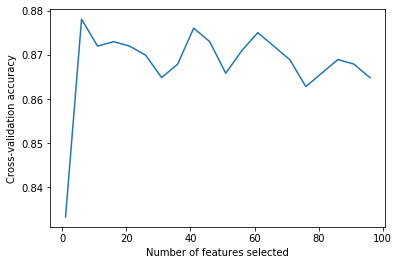

In [63]:
# Plot number of features vs. cross-validation scores.
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation accuracy')
plt.plot(percentiles, results)

In [64]:
# See if the performance improve.
fs = feature_selection.SelectPercentile(
    feature_selection.chi2,
    percentile=percentiles[optimal_percentil])

X_train_fs = fs.fit_transform(X_train, y_train)
dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
f'Accuracy: {metrics.accuracy_score(y_test, y_pred_fs):.3f}'

'Accuracy: 0.863'

In [65]:
# Model selection.
dt = tree.DecisionTreeClassifier(criterion='entropy')
scores = cross_val_score(dt, X_train_fs, y_train, cv=5)
f'Entropy criterion on accuracy on cv: {scores.mean():.3f}'

'Entropy criterion on accuracy on cv: 0.878'

In [66]:
# Model selection.
dt = tree.DecisionTreeClassifier(criterion='gini')
scores = cross_val_score(dt, X_train_fs, y_train, cv=5)
f'Gini criterion on accuracy on cv: {scores.mean():.3f}'

'Gini criterion on accuracy on cv: 0.882'

In [67]:
dt = dt.fit(X_train_fs, y_train)
X_test_fs = fs.transform(X_test)
y_pred_fs = dt.predict(X_test_fs)
f'Accuracy: {metrics.accuracy_score(y_test, y_pred_fs):.3f}'

'Accuracy: 0.863'